<a href="https://colab.research.google.com/github/imceballos/udd_homeworks/blob/main/Tarea2_MLAplicado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <h2>Modelos de lenguaje y clasificación de texto</h2>

Autor: Israel Ceballos

Profesor: Alonso Astroza

El objetivo de este trabajo es crear un clasificador de **reviews** en base a reseñas de **Amazon**

## *Instalación de libreria fastai*

In [1]:
!pip install fastai

In [2]:
!pip install fastai-ulmfit

     |████████████████████████████████| 1.2MB 7.5MB/s 
     |████████████████████████████████| 194kB 27.2MB/s 
     |████████████████████████████████| 61kB 10.3MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [3]:
from fastai.text import *
from fastai.text.all import *

from fastai_ulmfit.pretrained import *

Crearemos la carpeta data, esta nos servira pronto para almacenar la data 

In [4]:
path = Path('data')
dest = path
dest.mkdir(parents=True, exist_ok=True)

## <h2>Autenticación y descarga en GCP </h2>

La información esta alojada en GCP (Google Cloud Platform), para poder acceder a ella debe logerarse con su cuenta alonsoastroza@gmail.com, esta cuenta tiene habilitado los permisos para acceder a descargar la infromación.

In [5]:
!gcloud auth login

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=dmIEl9DN34mXWona5sDgJEpqPjgHav&prompt=consent&access_type=offline&code_challenge=JpkmivA3ZUeKt6k3vyLCAyip52zALqKFhWvF_eA4Z3g&code_challenge_method=S256

Enter verification code: 4/1AX4XfWjlC6xcujYBO1_y7kEVKJgdYpT5hBTJMM65SHIoB2OOrfCQzzCyL90

You are now logged in as [eliizabeth.fren@gmail.com].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


To take a quick anonymous survey, run:
  $ gcloud survey



### <h3>Descargamos la información de dataset_es_train</h3>

In [6]:
!gsutil cp -r  gs://tareaml2/dataset_es_train.json data/

Copying gs://tareaml2/dataset_es_train.json...
- [1 files][ 73.9 MiB/ 73.9 MiB]                                                
Operation completed over 1 objects/73.9 MiB.                                     


###<h3>Descargamos la información de dataset_es_test</h3>

In [7]:
!gsutil cp -r gs://tareaml2/dataset_es_test.json data/

Copying gs://tareaml2/dataset_es_test.json...
/ [1 files][  1.8 MiB/  1.8 MiB]                                                
Operation completed over 1 objects/1.8 MiB.                                      


##<h2>Carga de los datos (Pregunta 2.1)</h2>

In [8]:
import pandas as pd

Conjunto de entrenamiento

In [9]:
df_train = pd.read_json('data/dataset_es_train.json', lines=True)
df_train.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8 meses y no he recibido respuesta del fabricante,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ni nosotros que sabemos inglés, ni un informático, después de una hora fue capaz de instalarlo",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,"Te obligan a comprar dos unidades y te llega solo una y no hay forma de reclamar, una autentica estafa, no compreis!!",solo llega una unidad cuando te obligan a comprar dos,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo puedo decir que tras dos meses de espera.... sigo sin el producto y tuve que contactar con Amazon para reclamar su reembolso. Amazon un 10 . Se hace cargo del problema, pero yo e desembolsado mi dinero y en dos meses me lo devuelven Perdida de tiempo TOTAL. Sin palabras. Y Ustedes deciden",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes


Conjunto de validación

In [10]:
df_test = pd.read_json('data/dataset_es_test.json', lines=True)
df_test.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0038754,product_es_0113523,reviewer_es_0580071,1,no me llego el articulo me lo mando por correos normal sin seguimiento y nunca me llego tota un desastre,no me llego,es,wireless
1,es_0748979,product_es_0017036,reviewer_es_0819733,1,"la mensajería horrible, no compro mas",amazon sigue sin cumplir en las entregas,es,home
2,es_0411746,product_es_0138642,reviewer_es_0508607,1,Estoy muy decepcionado con el vendedor ya que el pedido no me llegó a tiempo y no cumplió los plazos de envío y era una cosa que necesitaba urgente. Para colmo me pongo en contacto con el vendedor y no da señales. No recomiendo nada,ESTAFA EN EL ENVÍO,es,toy
3,es_0786686,product_es_0170887,reviewer_es_0491157,1,"Mi valoración no es sobre el producto sino sobre AMAZON. Ofrecéis el producto a 299€ y tras varios días me devolvéis el dinero porque os habéis equivocado en el anuncio, según vosotros, ahora es 399€. Es la primera vez que me ocurre esto. Cuando he comprado en cualquier sitio y el precio marcado no se correspondía con el valor de caja siempre me lo han vendido con el precio marcado. Es inverosímil lo ocurrido, pero la ultima palabra me la dará la oficina del consumidor",Estafa de Amazon,es,home
4,es_0429700,product_es_0710642,reviewer_es_0008745,1,Pues tenía interés en este libro y probé la versión kindle. se abre la portada pero nada más. parece una mala broma pero me iba a gastar el dedo de tanto tratar que pasara de página de alguna forma. No puedo valorar nada de nada.,No conseguí pasar de la portada en Kindle,es,digital_ebook_purchase


###<h3>Número de stars y largo de reseñas</h3>

Conjunto de entrenamiento

In [11]:
df_train['stars'].value_counts()

5    40000
4    40000
3    40000
2    40000
1    40000
Name: stars, dtype: int64

In [12]:
reviews_train = df_train[['stars', 'review_body']].apply(lambda x: [x['stars'], len(x['review_body'])], axis=1).tolist()
df_reviews_train = pd.DataFrame(reviews_train, columns=['stars','len_reviews'])

In [13]:
df_reviews_train.groupby('stars').sum()

,len_reviews
stars,
1,6115339
2,6737550
3,6215212
4,5694288
5,5498193


Conjunto de validación

In [14]:
df_test['stars'].value_counts()

3    1000
2    1000
5    1000
1    1000
4    1000
Name: stars, dtype: int64

In [15]:
reviews_test = df_test[['stars', 'review_body']].apply(lambda x: [x['stars'], len(x['review_body'])], axis=1).tolist()
df_reviews_test = pd.DataFrame(reviews_test, columns=['stars','len_reviews'])

In [16]:
df_reviews_test.groupby('stars').sum()

,len_reviews
stars,
1,156122
2,164685
3,155265
4,143903
5,139596


##<h2>Entrenamiento del modelo (Pregunta 2.2)</h2>

###<h3>Tratamiento de los datos</h3>

Para entrenar este modelo usaremos ULMFIT, el cual se encuentra disponible en la siguiente url:

In [17]:
url = 'http://bit.ly/ulmfit-eswiki'
tok = tokenizer_from_pretrained(url)

Concatenación de dataframes

In [18]:
df_train['indicator'] = 0
df_test['indicator'] = 1

In [64]:
df_final_p1 = pd.concat([df_test, df_train])

In [20]:
df_final_p1.shape

(205000, 9)

Extraemos la información desde el *review_body* para aislarla en *df_lm_train*

In [21]:
df_lm_train = df_train[['review_body']]
df_lm_train.head()

,review_body
0,Nada bueno se me fue ka pantalla en menos de 8 meses y no he recibido respuesta del fabricante
1,"Horrible, nos tuvimos que comprar otro porque ni nosotros que sabemos inglés, ni un informático, después de una hora fue capaz de instalarlo"
2,"Te obligan a comprar dos unidades y te llega solo una y no hay forma de reclamar, una autentica estafa, no compreis!!"
3,"No entro en descalificar al vendedor, solo puedo decir que tras dos meses de espera.... sigo sin el producto y tuve que contactar con Amazon para reclamar su reembolso. Amazon un 10 . Se hace cargo del problema, pero yo e desembolsado mi dinero y en dos meses me lo devuelven Perdida de tiempo TOTAL. Sin palabras. Y Ustedes deciden"
4,Llega tarde y co la talla equivocada


In [65]:
dblocks = DataBlock(blocks=(TextBlock.from_df('review_body', tok=tok, is_lm=True)),
                    get_x=ColReader('text'), 
                    splitter=ColSplitter('indicator'))

dls = dblocks.dataloaders(df_final_p1, bs=64, seq_len=80)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [66]:
learn_p1 = language_model_from_pretrained(dls, url=url, drop_mult=1, metrics=[accuracy, Perplexity()]).to_fp16()

SuggestedLRs(valley=tensor(0.0021))

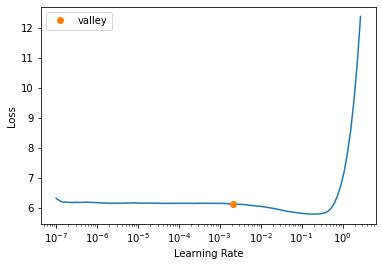

In [67]:
learn_p1.lr_find()

In [68]:
lr_p1 = 8e-3

In [69]:
learn_p1.fit_one_cycle(1, lr_p1 , moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.133668,3.917583,0.261337,50.278748,06:25


In [70]:
learn_p1.unfreeze()
learn_p1.fit_one_cycle(5, slice(lr_p1/100,lr_p1), moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.924033,3.758171,0.277405,42.869957,07:07
1,3.794633,3.637941,0.290167,38.013493,07:07
2,3.687465,3.566510,0.297967,35.392845,07:07
3,3.620711,3.522017,0.302826,33.852657,07:08
4,3.555001,3.512591,0.304533,33.535057,07:08


In [28]:
learn_p1.save('learner_p1a')

Path('models/learner_p1a.pth')

In [29]:
learn_p1.save_encoder('finetuned_language_model_encoder')

###<h3>Descarga del modelo</h3>

En caso de querer contar con el modelo preparado para su uso, se puede descargar desde GCP siguiendo los pasos anteriores con su correo.

In [25]:
path = Path('models')
dest = path
dest.mkdir(parents=True, exist_ok=True)

In [26]:
!gsutil cp -r  gs://tareaml2/learner_p1.pth models/

Copying gs://tareaml2/learner_p1.pth...
\ [1 files][301.1 MiB/301.1 MiB]                                                
Operation completed over 1 objects/301.1 MiB.                                    


In [27]:
learner = learn_p1.load('learner_p1')

##<h2>Resultados de la clasificación (Pregunta 2.3)</h2>

Generaremos tres reseñas en base al texto **"El producto llego en mal estado y como era de esperar"** con los valores de temperature: 0.5, 0.75, 1.75, 10. A partir de esto, analizaremos la diferencia en los textos generados con cada uno de los casos.

In [28]:
TEXT = "El producto llego en mal estado y como era de esperar"
N_WORDS = 80
N_SENTENCES = 3
preds = [learner.predict(TEXT, N_WORDS, temperature=0.5) 
         for _ in range(N_SENTENCES)]

In [29]:
print("\n".join(preds))

▁xxbos ▁xxmaj ▁el ▁producto ▁llego ▁en ▁mal ▁estado ▁y ▁como ▁era ▁de ▁esperar , ▁me ▁ha ▁llegado ▁con ▁un ▁golpe ▁en ▁la ▁parte ▁de ▁arriba ▁y ▁el ▁otro ▁en ▁el ▁lateral ▁por ▁lo ▁que ▁no ▁puedo ▁opinar . ▁xxbos ▁xxmaj ▁no ▁se ▁ajusta ▁bien ▁al ▁teléfono , ▁no ▁se ▁adapta ▁bien ▁al ▁teléfono . ▁xxmaj ▁no ▁lo ▁recomiendo . ▁xxbos ▁xxmaj ▁es ▁la ▁tercera ▁vez ▁que ▁lo ▁compro , ▁y ▁la ▁verdad ▁que ▁no ▁puedo ▁opinar ▁porque ▁me ▁ha ▁llegado ▁con ▁el ▁precinto ▁del ▁paquete ▁abierto , ▁un ▁desastre , ▁no ▁le ▁pongo
▁xxbos ▁xxmaj ▁el ▁producto ▁llego ▁en ▁mal ▁estado ▁y ▁como ▁era ▁de ▁esperar , ▁la ▁entrega ▁fue ▁rápido ▁y ▁el ▁producto ▁fue ▁correcto . ▁xxbos ▁xxmaj ▁la ▁verdad ▁es ▁que ▁el ▁producto ▁tiene ▁buena ▁pinta , ▁pero ▁no ▁es ▁lo ▁que ▁esperaba , ▁es ▁más ▁pequeño ▁que ▁el ▁original . ▁xxmaj ▁la ▁calidad ▁de ▁la ▁imagen ▁es ▁muy ▁buena . ▁xxbos ▁xxmaj ▁muy ▁buena ▁calidad , ▁pero ▁no ▁se ▁adapta ▁bien ▁a ▁los ▁bordes , ▁no ▁tiene ▁suficiente ▁fuerza ▁y ▁se ▁despega . ▁xxmaj ▁

In [35]:
TEXT = "El producto llego en mal estado y como era de esperar"
N_WORDS = 80
N_SENTENCES = 3
preds = [learner.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [36]:
print("\n".join(preds))

▁xxbos ▁xxmaj ▁el ▁producto ▁llego ▁en ▁mal ▁estado ▁y ▁como ▁era ▁de ▁esperar ▁por ▁el ▁producto ▁es ▁bastante ▁incómodo ▁al ▁momento ▁de ▁comprarlo ▁no ▁merece ▁la ▁pena ▁comprarlo ▁xxbos ▁xxmaj ▁se ▁me ▁cayó ▁al ▁suelo ▁en ▁mi ▁caso ▁y ▁el ▁material ▁se ▁ha ▁roto ▁al ▁poco ▁tiempo . ▁xxmaj ▁no ▁lo ▁recomiendo , ▁dinero ▁tirado . ▁xxbos ▁xxmaj ▁todo ▁perfecto , ▁buen ▁producto ▁xxbos ▁xxmaj ▁el ▁producto ▁es ▁correcto ▁y ▁la ▁calidad ▁es ▁buena . ▁xxmaj ▁el ▁producto ▁que ▁es ▁el ▁que ▁se ▁describe , ▁es ▁de ▁plástico ▁y ▁viene ▁con ▁funda ▁para
▁xxbos ▁xxmaj ▁el ▁producto ▁llego ▁en ▁mal ▁estado ▁y ▁como ▁era ▁de ▁esperar . ▁xxmaj ▁no ▁me ▁parece ▁muy ▁buena ▁calidad . ▁xxmaj ▁no ▁lo ▁recomiendo ▁xxbos ▁xxmaj ▁me ▁han ▁llegado ▁2 ▁bombillas ▁y ▁no ▁hay ▁manera ▁de ▁contactar ▁con ▁el ▁vendedor ▁para ▁solucionar ▁el ▁problema . ▁xxmaj ▁muy ▁descontento ▁xxbos ▁xxmaj ▁este ▁producto ▁no ▁es ▁nuevo , ▁solo ▁tiene ▁dos ▁tornillos ▁de ▁fijación . ▁xxmaj ▁es ▁una ▁pena ▁que ▁venga ▁abiert

In [37]:
TEXT = "El producto llego en mal estado y como era de esperar"
N_WORDS = 80
N_SENTENCES = 3
preds = [learner.predict(TEXT, N_WORDS, temperature=1.75) 
         for _ in range(N_SENTENCES)]

In [38]:
print("\n".join(preds))

▁xxbos ▁xxmaj ▁el ▁producto ▁llego ▁en ▁mal ▁estado ▁y ▁como ▁era ▁de ▁esperar ▁posee ▁2 ▁to liquid ▁rotuladores ▁redondeados ▁plegada s , ▁hacerme ▁valen ▁25 ▁pelín ▁vueltas ▁al ▁embutido ▁45 5 ▁paquetes ▁se ▁muestra ▁em ▁zapatos ▁anteriormente ▁defraudo ▁te ▁importe ▁periódicamente ▁mejor ▁busca ▁este ▁migas ▁experta . ▁adquirir ▁crema ▁tipo ▁can ut ▁perfecto amente ▁muchos ▁productos ▁dorado ▁pues ▁tener ▁buscando ▁dentro ▁sobres ▁antimosquitos ▁estéticamente ▁pasó ▁aplastada s ▁burbujas ▁q ▁al ▁pierdan ▁fresco ▁atentos ▁ganas ▁resistentes ▁observa ▁conservación ▁frascos ▁eran ▁pese ▁ir ▁bien ▁encuentras ▁atrevido ▁para ▁lavar ▁más ▁combinaciones ▁compradas ▁xxbos ▁la ▁ventosa ▁puede
▁xxbos ▁xxmaj ▁el ▁producto ▁llego ▁en ▁mal ▁estado ▁y ▁como ▁era ▁de ▁esperar ▁ir ▁pues ▁diria ▁60 ▁- ▁laboratorio ▁teniendo ▁capacidad ▁muy ▁ocupe ▁recargarla ▁ ▁encontra ▁nutricional mente ▁voto s ▁podometro ▁fijas . ▁ñapa s ▁horizontales ▁xxbos ▁me ▁acabo ▁teniendo ▁por ▁abrirlo ▁v u ste ▁procedente

In [39]:
TEXT = "El producto llego en mal estado, "
N_WORDS = 80
N_SENTENCES = 3
preds = [learner.predict(TEXT, N_WORDS, temperature=10) 
         for _ in range(N_SENTENCES)]

In [40]:
print("\n".join(preds))

▁xxbos ▁xxmaj ▁el ▁producto ▁llego ▁en ▁mal ▁estado , ▁sirviendo ▁podria ▁dejadez ▁pico ▁instalamos ▁limpiacristales ▁semiprofesional ▁fieltro pk ▁criterio ▁kit ▁lg ▁analizar endo ▁termo ▁mundo ▁buena ▁razer ▁calzo ▁habiéndo ▁cervicales ▁promociona ▁ancho ▁enroscar ▁ups ▁esenciales ▁mòbil ▁colorines ▁mapa ▁programable version ▁asequible ▁motivo ▁aquel ▁utilizarlo ▁tubiera ▁matices ▁durabilidad ▁ryanair ▁contexto ▁varias dado ▁actual ▁calculo ▁introduzc ▁desconecte ▁requerido ana ▁descosida ▁traía volv ▁conduciendo ▁translúcido gen ▁éstas ▁abierto ▁compensar ▁amarilla ▁pequeñitas ▁desgastando ▁engrasar ▁cura ▁recolocar ▁enviado ▁pasadores ▁fichas ▁aguanta ▁bbq ▁había ▁descosido sistir ▁cuaderno encaja ▁difiere ▁relativo ▁factor ▁motor ▁alcohol ▁sonoro me
▁xxbos ▁xxmaj ▁el ▁producto ▁llego ▁en ▁mal ▁estado , ▁deshace ▁perderse ▁martillo ▁alternativo ▁lucecita ▁terminar ▁trasladar gafas ▁modelismo ▁borre ▁jajaja ▁asegurar ▁adaptabilidad ▁partio ▁ambos ▁secador ▁episodio azúl ▁traqueteo ▁t

En base al siguiente [link](https://pytorch-nlp-tutorial-ny2018.readthedocs.io/en/latest/day2/sampling.html), consideremos que el aumento se relaciona con que tan fuerte muestreamos la distribución, a medida que el más alto el valor de **temperature** más uniforme es la distribución y cuando el valor es bajo, se observan pocas diferencias entre los textos generados.

En palabras más simples, si observamos el primer caso (**temperature=0.5**) se puede observar una alta similitud en las palabras usadas por el generador como pantalla o vendedor, el uso de palabras y conectores similares hace que la diferencias entre sentencias sea más baja. Por otro lado, a medida que aumenta el valor de temperature la distribución de palabras tiende a ser más uniforme, en el sentido que se usa una mayor cantidad de palabras con una frequencia baja o igual a uno, esta uniformidad trae como consecuencia que el texto generado pierda coherencia.



This is a commit

In [30]:
from fastai.vision.widgets import *

In [35]:
df_final_p2 = df_final_p1[['review_body','stars', 'indicator']]

In [36]:
df_final_p2.head()

,review_body,stars,indicator
0,no me llego el articulo me lo mando por correos normal sin seguimiento y nunca me llego tota un desastre,1,1
1,"la mensajería horrible, no compro mas",1,1
2,Estoy muy decepcionado con el vendedor ya que el pedido no me llegó a tiempo y no cumplió los plazos de envío y era una cosa que necesitaba urgente. Para colmo me pongo en contacto con el vendedor y no da señales. No recomiendo nada,1,1
3,"Mi valoración no es sobre el producto sino sobre AMAZON. Ofrecéis el producto a 299€ y tras varios días me devolvéis el dinero porque os habéis equivocado en el anuncio, según vosotros, ahora es 399€. Es la primera vez que me ocurre esto. Cuando he comprado en cualquier sitio y el precio marcado no se correspondía con el valor de caja siempre me lo han vendido con el precio marcado. Es inverosímil lo ocurrido, pero la ultima palabra me la dará la oficina del consumidor",1,1
4,Pues tenía interés en este libro y probé la versión kindle. se abre la portada pero nada más. parece una mala broma pero me iba a gastar el dedo de tanto tratar que pasara de página de alguna forma. No puedo valorar nada de nada.,1,1


In [ ]:
dblocks_p2 = DataBlock(blocks=(TextBlock.from_df('review_body'), CategoryBlock),
                       get_x=ColReader('text'), splitter=ColSplitter('indicator'))


In [50]:
dls_blk = DataBlock(blocks = (TextBlock.from_df(text_cols = "review_body", seq_len = 128),
                              MultiCategoryBlock),
                    get_x = ColReader(cols = "text"), get_y = ColReader(cols="stars"),
                    splitter=ColSplitter('indicator'))

In [47]:
df_final_p1 = df_final_p1.astype({"stars": str})

In [51]:
df_final_p1.dtypes

review_id           object
product_id          object
reviewer_id         object
stars               object
review_body         object
review_title        object
language            object
product_category    object
indicator            int64
dtype: object

In [57]:
dls_clf = dls_blk.dataloaders(df_final_p1, bs=64, seq_len=128)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [58]:
dls_clf.show_batch()

,text,None
0,"xxbos xxmaj hago estos cambios en mi opinión , no por el producto , si no por el vendedor . xxmaj me puse en contacto con el vendedor para que me diera una solución sobre el problema de conectar los discos a través de un xxup hub . xxmaj me dijo que tenia que funcionar , y que si no me enviaría otro sin costo . xxmaj seguí sus instrucciones y como no funcionaron , me pidieron que enviara el aparato a una dirección internacional asumiendo yo el coste ( y fuera de la mediación de xxmaj amazon ) , xxmaj cuando le pregunte por esos costes ( que son superiores al precio del articulo ) , me indicaron que los pagara , que luego ya me los devolverían . y que luego también me enviarían uno nuevo . xxmaj me ha parecido todo muy informal y poco ético .",5
1,"xxbos xxmaj quería unas botas de agua que fueran un poco más "" xxunk "" y , después de mirar bastantes modelos , me decidí por estas . xxmaj tengo la talla 41 en casi todo el calzado que utilizo , pero las opiniones que había leído aquí me hicieron dudar y de entrada solicité una talla menos . xxmaj son cómodas de quitar y poner , pero por delante me quedaban estrechas . xxmaj al final tuve que pedir mi talla de siempre . xxmaj las he usado en día de lluvia y parecen cumplir su función . xxmaj no obstante , les doy sólo 3 estrellas porque para mí estas botas tienen un problema , y es que no hay xxunk entre la anchura de la caña y la parte que envuelve el pie . xxmaj cuando me las pongo me da la sensación de que quedan grandes",3
2,xxbos xxmaj debajo mantengo la reseña inicial para que la podáis leer pero lo . xxmaj puse un día por la noche y a la mañana siguiente me llama mi mujer para decirme que el táctil no le va bien y que xxmaj le costaba escribir mucho . xxmaj no se si le pasa a todo el mundo que lo ha comprado . xxmaj me gustaria saberlo para pedir otro igual o devolverlo . xxmaj en el caso de lo que buscamos en los cristales templados que es protección pues gracias a dios no he podido comprobar su eficacia así que voy a valorar el resto . xxmaj es el mejor protector de pantalla de los que he comprado hasta la fecha para todos los dispositivos que he tenido . xxmaj aparenta bastante calidad y me ha dejado impresionado lo bien preparado que viene para su colocación de manera que,2
3,"xxbos xxmaj me preocupan dos cosas : xxmaj primero como se puede vender esto por casi cuarenta euros . xxmaj la he utilizado exactamente tres veces , el jueves a las nueve de la noche en un monte intentando arreglar esta xxup m. estaba más vendido que vendido , a una hora y media de casa sin luz . xxmaj está mal diseñada la xxunk , la pieza a modo de puente ) que une el foco al manillar esta unida por un tornillo de porquería que a poco que se mueva se suelta y se rompen lo cables . xxmaj me entró agua . xxmaj la batería no dura un asalto . xxmaj no sé que más me puede pasar . xxmaj un auténtico fiasco . xxmaj otra cosa que me preocupa , -y también por xxmaj xxunk , si te fías de los comentarios que ponéis , no",1
4,"xxbos xxmaj la talla queda como se espera , sin embargo estos calcetines deportivos de mujer oprimen el pie más que otros : el tejido es bastante más grueso en conjunto de lo que cabe esperar y esto se xxunk por el exceso de elástico en las bandas del empeine , a pesar de que mis pies son delgados y toleran bien estas bandas con otras marcas . xxmaj la descripción habla del xxunk en la planta ( razón por la que los compré ) , pero no del espesor de toda la prenda . xxmaj otra cosa que me desagrada cuando los llevo es que no transpiran lo suficiente por la proporción tan baja de algodón , seguramente , así que me dan mucho calor incluso con temperaturas bajas . xxmaj cierran más arriba que los de xxmaj puma o xxmaj nike en el talón , y también la",1
5,"xxbos xxup ventajas : 1 . xxmaj protege sin problema toda la pantalla 2 . xxmaj muy barato teniendo en cuenta que incluye 3 y es más barato que otros que solo incluyen 1 protector xxup contras : 1 . xxmaj no se pega por tod

In [59]:
learn_clf = text_classifier_learner(dls_clf, AWD_LSTM, drop_mult=0.3,metrics = accuracy).to_fp16()

In [60]:
learn_clf = learn_clf.load_encoder("finetuned_language_model_encoder")

RuntimeError: ignored

In [61]:
learn_clf.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time


AssertionError: ignored

In [8]:
data_clas = TextClasDataBunch.from_df(train_df = df_train, valid_df = df_test, path = "", vocab=data_lm.train_ds.vocab, bs=64, text_cols='review_body', label_cols='stars', tok=tok, is_lm=True)

NameError: ignored

In [35]:
data_clas.show_batch()

text,target
"xxbos xxmaj hago estos cambios en mi opinión , no por el producto , si no por el vendedor . xxmaj me puse en contacto con el vendedor para que me diera una solución sobre el problema de conectar los discos a través de un xxup hub . xxmaj me dijo que tenia que funcionar , y que si no me enviaría otro sin costo . xxmaj seguí sus instrucciones",5
"xxbos xxmaj tengo problemas de insomnio , y suelo trabajar y leer con poca luz , pero esa falta de luz estaba pasando factura a mi vista , por eso buscaba algo que me ayudase , se esa forma he encontrado esta doble luz que se enfoca donde quieres , sin cables , y con tres intensidades de luz , que me lo ha solucionado . xxmaj esta hecha de",5
"xxbos xxmaj que me ha gustado : xxmaj su diseño , la boca ancha , la textura de los materiales y la agradable sensación al tacto . xxmaj bastante silenciosa al hervir el gua comprado con otros modelos de hervidores eléctricos . xxmaj que no me ha gustado : xxmaj la compré porque se conecta con xxmaj google xxmaj home y se supone que se puede controlar con el móvil",2
"xxbos xxmaj no me quejo por los materiales de construccion los cuales son de una calidad media / alta ( quiero decir no son basicos ) , todos los plasticos son duros , viene con el fondo del bebedero de material inox lo cual es mucho mejor que el plastico ya que es mas higienico . xxmaj las goma / silicona que divide la base plastica del bebedero inox tambien",2
"xxbos xxmaj me considero un amante de las mochilas , siempre estoy buscando la más práctica pero a la vez que no pierda estilo . xxmaj llevaba mucho tiempo mirando alguna que me evitara tener que llevar al trabajo una mochila y a parte una bolsa térmica para la comida que me preparo en casa , ya que voy 20 minutos en bici y se hace incomodo llevar más bolsas",5


In [36]:
learn_p2 = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [37]:
learn_p2.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.91E-02
Min loss divided by 10: 9.12E-02


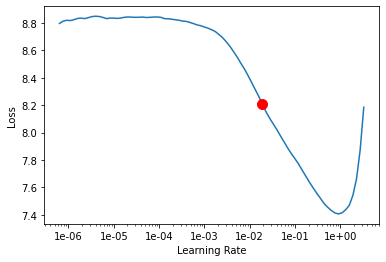

In [38]:
learn_p2.recorder.plot(suggestion=True)
min_grad_lr = learn_p2.recorder.min_grad_lr

In [40]:
learn_p2.fit_one_cycle(3, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: ignored